### Class Activation Mapping and retrieving an Explanation Weight Vector

In this notebook we extract the class activation maps from the weights of the neural network and save an explanation weight vector. The use of the CAM was orignally proposed by Zhou et al and in time series Wang et al extended this work. Fawaz et al used this approach in an excellent review paper on DNNs for TSC and the supplied code is an adaptation of the code provided there.

In [1]:
import tensorflow as tf
from tensorflow import keras
import time
tf.get_logger().setLevel(40) # suppress deprecation messages
tf.compat.v1.disable_v2_behavior() # disable TF2 behaviour as alibi code still relies on TF1 constructs
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Conv1D, GlobalAveragePooling1D, BatchNormalization, Conv2D
from tensorflow.keras.layers import GlobalAveragePooling1D
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.backend import function
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
import sklearn
from scipy.spatial.distance import cdist, pdist
from scipy import stats
from sklearn.neighbors import DistanceMetric
from tslearn.datasets import UCR_UEA_datasets
from tslearn.neighbors import NearestNeighbors, KNeighborsTimeSeries
from sklearn.metrics import accuracy_score
from scipy.interpolate import interp1d
from sklearn import preprocessing
print('TF version: ', tf.__version__)
print('Eager execution enabled: ', tf.executing_eagerly()) # False
from counterfactual_utils import label_encoder, ucr_data_loader
%matplotlib inline

TF version:  2.4.1
Eager execution enabled:  False
TF version:  2.4.1
Eager execution enabled:  False


### Class Activation Mapping

We load the pretrained FCN model and use Class Activation Mapping to locate discriminative areas of the time series.

In [2]:
def cam_plotter(dataset):
    
    """The dataset here will be the one which we traind the FCN on and saved the corresponding best model"""
    
    
    X_train, y_train, X_test, y_test = ucr_data_loader(str(dataset))
    y_train, y_test = label_encoder(y_train, y_test)
    
    
    model = keras.models.load_model(str(dataset) + '_best_model.hdf5')
    
    x_train=X_train


    max_length = 2000
    enc = sklearn.preprocessing.OneHotEncoder()
    enc.fit(np.concatenate((y_train, y_test), axis=0).reshape(-1, 1))
    y_train_binary = enc.transform(y_train.reshape(-1, 1)).toarray()

    x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], 1)


    w_k_c = model.layers[-1].get_weights()[0]  # weights for each filter k for each class c

    # the same input
    new_input_layer = model.inputs
    # output is both the original as well as the before last layer
    new_output_layer = [model.layers[-3].output, model.layers[-1].output]

    new_feed_forward = keras.backend.function(new_input_layer, new_output_layer)

    classes = np.unique(y_train)

    for c in [0]: #the class
        plt.figure()
        count = 0
        c_x_train = x_train[np.where(y_train == c)]
        for ts in c_x_train:
            ts = ts.reshape(1, -1, 1)
            [conv_out, predicted] = new_feed_forward([ts])
            pred_label = np.argmax(predicted)
            orig_label = np.argmax(enc.transform([[c]]))
            if pred_label == orig_label:
                cas = np.zeros(dtype=np.float, shape=(conv_out.shape[1]))
                for k, w in enumerate(w_k_c[:, orig_label]):
                    cas += w * conv_out[0, :, k]

                minimum = np.min(cas)

                cas = cas - minimum

                cas = cas / max(cas)
                cas = cas * 100

                x = np.linspace(0, ts.shape[1] - 1, max_length, endpoint=True)
                # linear interpolation to smooth
                f = interp1d(range(ts.shape[1]), ts[0, :, 0])
                y = f(x)
                # if (y < -2.2).any():
                #     continue
                f = interp1d(range(ts.shape[1]), cas)
                cas = f(x).astype(int)
                plt.scatter(x=x, y=y, c=cas, cmap='jet', marker='.', s=2, vmin=0, vmax=100, linewidths=0.0)
                #plt.ylabel('Signal',  fontsize='xx-large', fontweight='bold')

        cbar = plt.colorbar()
    #plt.savefig('../Images/' + str(dataset) +'.pdf')
        # cbar.ax.set_yticklabels([100,75,50,25,0])


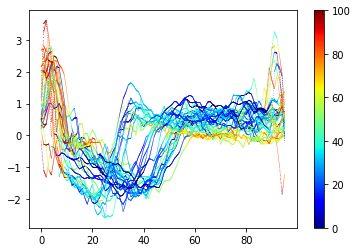

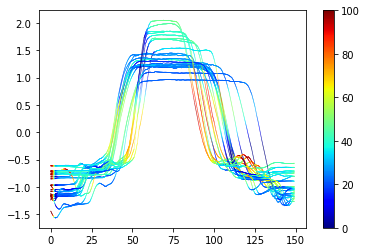

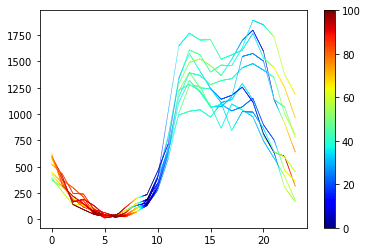

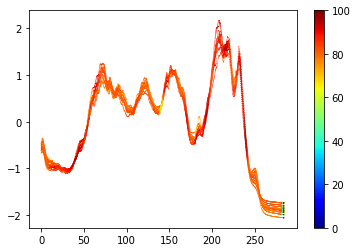

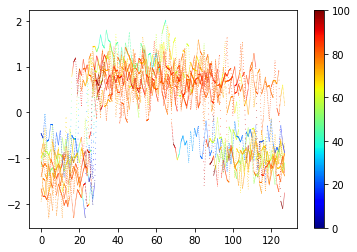

In [3]:
for dataset in ['ecg200', 'gunpoint', 'chinatown','coffee', 'CBF']:
    cam_plotter(dataset)

### Retreiving and saving CAM Weights
We can save the training and testing weights from the Classifier

In [4]:
### Training Weights
def training_weights_cam(dataset, save_weights):
    
    X_train, y_train, X_test, y_test = ucr_data_loader(str(dataset))
    y_train, y_test = label_encoder(y_train, y_test)
    
    
    model = keras.models.load_model(str(dataset) + '_best_model.hdf5')
    
    w_k_c = model.layers[-1].get_weights()[0]

    new_input_layer = model.inputs
    # output is both the original as well as the before last layer
    new_output_layer = [model.layers[-3].output, model.layers[-1].output]

    new_feed_forward = keras.backend.function(new_input_layer, new_output_layer)




    weights = []
    for i, ts in enumerate(X_train):
        ts = ts.reshape(1,-1,1)
        [conv_out, predicted] = new_feed_forward([ts])
        pred_label = np.argmax(predicted)

        cas =   np.zeros(dtype=np.float, shape=(conv_out.shape[1]))
        for k, w in enumerate(w_k_c[:, pred_label]):
            cas += w * conv_out[0,:, k]
        weights.append(cas)
    weights = np.array(weights)
    
    if save_weights == True:
        
        np.save(str(dataset)+'_cam_train_weights.npy', weights)
        
    return weights

In [5]:
def testing_weights_cam(dataset, save_weights):
    
    X_train, y_train, X_test, y_test = ucr_data_loader(str(dataset))
    y_train, y_test = label_encoder(y_train, y_test)
    

    model = keras.models.load_model(str(dataset) + '_best_model.hdf5')
    
    w_k_c = model.layers[-1].get_weights()[0]

    new_input_layer = model.inputs
    # output is both the original as well as the before last layer
    new_output_layer = [model.layers[-3].output, model.layers[-1].output]

    new_feed_forward = keras.backend.function(new_input_layer, new_output_layer)


    weights = []
    for i, ts in enumerate(X_test):
        ts = ts.reshape(1,-1,1)
        [conv_out, predicted] = new_feed_forward([ts])
        pred_label = np.argmax(predicted)

        cas =   np.zeros(dtype=np.float, shape=(conv_out.shape[1]))
        for k, w in enumerate(w_k_c[:, pred_label]):
            cas += w * conv_out[0,:, k]
        weights.append(cas)
    weights = np.array(weights)
    
    
    if save_weights == True:
        
        np.save(str(dataset)+'_cam_test_weights.npy', weights)
        
    return weights
   

In [6]:
#for dataset in ['ecg200', 'coffee', 'gunpoint', 'CBF', 'chinatown']:
    
#    training_weights_cam(dataset, save_weights=True)
#    testing_weights_cam(dataset, save_weights=True)

#weights and models will save in current working directory